In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# - !wget https://mirror.jframeworks.com/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!wget https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
#    https://spark.apache.org/downloads.html -> click on Download Spark: spark-3.5.4-bin-hadoop3.tgz
!tar xvf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark==3.5.5
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.5-bin-hadoop3"
#- Run the followings:

--2025-03-04 18:47:23--  https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz’

spark-3.5.5-bin-had 100%[===================>] 382.16M   225MB/s    in 1.7s    

2025-03-04 18:47:25 (225 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz’ saved [400724056/400724056]

spark-3.5.5-bin-hadoop3/
spark-3.5.5-bin-hadoop3/jars/
spark-3.5.5-bin-hadoop3/jars/HikariCP-2.5.1.jar
spark-3.5.5-bin-hadoop3/jars/JLargeArrays-1.5.jar
spark-3.5.5-bin-hadoop3/jars/JTransforms-3.1.jar
spark-3.5.5-bin-hadoop3/jars/RoaringBitmap-0.9.45.jar
spark-3.5.5-bin-hadoop3/jars/ST4-4.0.4.jar
spark-3.5.5-bin-hadoop3/jars/activation-1.1.1.jar
spark-3.5.5-bin-hadoop3/jars/aircompressor-0.27.jar
spark-3.5.5-bin-hadoop3/jars/alge

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('XGBoost').getOrCreate()

In [4]:
# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
file_type = "csv"

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter).csv("/content/drive/MyDrive/HousingPriceRegression/Data/kc_house_data_final.csv")

In [5]:
df.show()
df.printSchema()

+----------+----+--------+---------+------------------+------------------+------+----------+----+---------+-----+-----------------+-------+-------+--------+-----------------+------------------+------------------+---------+----------------------+
|        id|date|bedrooms|bathrooms|       sqft_living|          sqft_lot|floors|waterfront|view|condition|grade|    sqft_basement|zipcode|    lat|    long|    sqft_living15|        sqft_lot15|             price|house_age|years_since_renovation|
+----------+----+--------+---------+------------------+------------------+------+----------+----+---------+-----+-----------------+-------+-------+--------+-----------------+------------------+------------------+---------+----------------------+
|7129300520|NULL|     3.0|      1.0| 7.074116816197362| 8.639587799629844|     1|         0|   0|        3|    7|             NULL|  98178|47.5112|-122.257|7.201170883281678| 8.639587799629844|12.309986615445005|       70|                  NULL|
|6414100192|NULL

In [6]:
from pyspark.sql.functions import when, col

df = df.withColumn(
    "sqft_basement",
    when(col("sqft_basement").isNull(), 0)
    .otherwise(col("sqft_basement"))
)

df = df.withColumn(
    "years_since_renovation",
    when(col("years_since_renovation").isNull(), col("house_age"))
    .otherwise(col("years_since_renovation"))
)


In [7]:
df = df.drop('id', 'date', 'lat', 'long')
df.printSchema()


root
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)
 |-- price: string (nullable = true)
 |-- house_age: string (nullable = true)
 |-- years_since_renovation: string (nullable = true)



In [8]:
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

integer_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'house_age', 'years_since_renovation', 'zipcode', 'sqft_living15', 'sqft_lot15']
double_columns = ['price', 'bathrooms', 'floors']

for column in integer_columns:
  df = df.withColumn(column, col(column).cast(IntegerType()))

for column in double_columns:
  df = df.withColumn(column, col(column).cast(DoubleType()))

df.printSchema()


root
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- house_age: integer (nullable = true)
 |-- years_since_renovation: integer (nullable = true)



In [9]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|summary|          bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|     sqft_basement|           zipcode|     sqft_living15|        sqft_lot15|             price|         house_age|years_since_renovation|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|  count|             21613|         

In [10]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

In [11]:
test_data.show()

+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_basement|zipcode|sqft_living15|sqft_lot15|             price|house_age|years_since_renovation|
+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|       0|      0.0|          7|       6|   3.0|         0|   2|        3|    8|            0|  98133|            7|         7|12.847929163278053|       19|                    19|
|       0|      0.0|          8|      10|   2.0|         0|   0|        3|   12|            0|  98053|            8|        10|14.074523829505804|       35|                    35|
|       0|      2.5|          7|       9|   2.0|         0|   0|        3|    8|            0|  9804

In [12]:
train_data.show()

+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_basement|zipcode|sqft_living15|sqft_lot15|             price|house_age|years_since_renovation|
+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|       0|      0.0|          5|       9|   1.0|         0|   0|        1|    1|            0|  98024|            7|        10|11.863589378812122|       62|                    62|
|       0|      0.0|          6|       8|   1.0|         0|   0|        4|    7|            0|  98001|            7|         9|11.849047640327147|      112|                   112|
|       0|      0.0|          7|       8|   2.0|         0|   0|        3|    7|            0|  9806

In [15]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

categorical_features_ordinal = ['bedrooms', 'floors', 'view', 'condition', 'grade']
numerical_features = ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'house_age']

# Ordinal Encoding using StringIndexer
ordinal_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep") for col in categorical_features_ordinal]

# StandardScaler for numerical features
vector_assembler = VectorAssembler(inputCols=numerical_features, outputCol="num_features_vector")
scaler = StandardScaler(inputCol="num_features_vector", outputCol="num_features_scaled", withMean=True, withStd=True)

# One-Hot Encoding for Zipcode
zipcode_indexer = StringIndexer(inputCol="zipcode", outputCol="zipcode_indexed", handleInvalid="keep")
zipcode_encoder = OneHotEncoder(inputCol="zipcode_indexed", outputCol="zipcode_ohe")

# Assemble final features
feature_assembler = VectorAssembler(
    inputCols=[f"{col}_indexed" for col in categorical_features_ordinal] + ["num_features_scaled", "zipcode_ohe"],
    outputCol="final_features"
)

# Define PySpark Pipeline
preprocessor = Pipeline(stages=ordinal_indexers + [vector_assembler, scaler, zipcode_indexer, zipcode_encoder, feature_assembler])


In [16]:
# **Fit only on training data**
fitted_pipeline = preprocessor.fit(train_data)

# Transform both training and test sets
train_df_transformed = fitted_pipeline.transform(train_data)
test_df_transformed = fitted_pipeline.transform(test_data)

In [17]:
train_df_transformed = train_df_transformed.select('price', 'final_features')
train_df_transformed.show()

+------------------+--------------------+
|             price|      final_features|
+------------------+--------------------+
|11.863589378812122|(82,[0,3,4,5,6,7,...|
|11.849047640327147|(82,[0,3,5,6,7,8,...|
|12.367345048436391|(82,[0,1,5,6,7,8,...|
|12.779875885354993|(82,[0,1,4,5,6,7,...|
| 13.90626583447433|(82,[0,1,2,5,6,7,...|
|12.487488878546145|(82,[0,4,5,6,7,8,...|
|12.337105293891872|(82,[0,3,4,5,6,7,...|
|12.570719231334277|(82,[0,1,5,6,7,8,...|
|12.388398368982115|(82,[0,1,5,6,7,8,...|
|12.676079399771027|(82,[0,1,5,6,7,8,...|
|11.225256725762893|(82,[0,4,5,6,7,8,...|
|13.089842251812337|(82,[0,3,5,6,7,8,...|
|12.449022745701502|(82,[0,4,5,6,7,8,...|
| 12.52815976788113|(82,[0,3,4,5,6,7,...|
|12.577639650232573|(82,[0,3,4,5,6,7,...|
|12.644330802262578|(82,[0,3,4,5,6,7,...|
|11.289794413577894|(82,[0,3,4,5,6,7,...|
| 12.54254845357358|(82,[0,4,5,6,7,8,...|
|12.768544351446794|(82,[0,4,5,6,7,8,...|
|11.728044909070785|(82,[0,4,5,6,7,8,...|
+------------------+--------------

In [18]:
test_df_transformed = test_df_transformed.select('price', 'final_features')
test_df_transformed.show()

+------------------+--------------------+
|             price|      final_features|
+------------------+--------------------+
|12.847929163278053|(82,[0,1,2,4,5,6,...|
|14.074523829505804|(82,[0,1,4,5,6,7,...|
|12.736556768559339|(82,[0,1,4,5,6,7,...|
| 12.54254845357358|(82,[0,3,4,5,6,7,...|
|12.409017571151187|(82,[0,4,5,6,7,8,...|
|12.216027926866138|(82,[0,4,5,6,7,8,...|
|12.513561021741964|(82,[0,2,5,6,7,8,...|
| 12.04355959836804|(82,[0,2,4,5,6,7,...|
|12.608202196848836|(82,[0,4,5,6,7,8,...|
|11.957617696467539|(82,[0,4,5,6,7,8,...|
|12.206077645517674|(82,[0,4,5,6,7,8,...|
|13.176000822123365|(82,[0,4,5,6,7,8,...|
|12.779875885354993|(82,[0,2,3,4,5,6,...|
|12.299112067295642|(82,[0,4,5,6,7,8,...|
|12.708667489167874|(82,[0,5,6,7,8,9,...|
| 12.59473402514672|(82,[0,3,5,6,7,8,...|
|12.539687231525832|(82,[0,4,5,6,7,8,...|
|11.571203807011969|(82,[0,4,5,6,7,8,...|
| 12.34148164933907|(82,[0,4,5,6,7,8,...|
|12.886643575525625|(82,[0,4,5,6,7,8,...|
+------------------+--------------

In [20]:
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator


xgb = SparkXGBRegressor(features_col="final_features", label_col="price")


In [21]:
model = xgb.fit(train_df_transformed)

INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [23]:
predictions = model.transform(test_df_transformed)

In [24]:
predictions.show(5)

+------------------+--------------------+------------------+
|             price|      final_features|        prediction|
+------------------+--------------------+------------------+
|12.847929163278053|(82,[0,1,2,4,5,6,...|12.604040145874023|
|14.074523829505804|(82,[0,1,4,5,6,7,...|13.898116111755371|
|12.736556768559339|(82,[0,1,4,5,6,7,...|12.664785385131836|
| 12.54254845357358|(82,[0,3,4,5,6,7,...|12.031068801879883|
|12.409017571151187|(82,[0,4,5,6,7,8,...| 11.69802474975586|
+------------------+--------------------+------------------+
only showing top 5 rows



In [25]:
from pyspark.sql.functions import expm1

## IMPORTANT: Need to convert predictions back to original scale
predictions = predictions.withColumn("price_predicted", expm1(col("prediction")))
predictions = predictions.withColumn("original_price", expm1(col("price")))

In [26]:
predictions.show(5)

+------------------+--------------------+------------------+------------------+------------------+
|             price|      final_features|        prediction|   price_predicted|    original_price|
+------------------+--------------------+------------------+------------------+------------------+
|12.847929163278053|(82,[0,1,2,4,5,6,...|12.604040145874023|  297758.128754903| 379999.9999999999|
|14.074523829505804|(82,[0,1,4,5,6,7,...|13.898116111755371|1086112.3107662601|1295649.9999999993|
|12.736556768559339|(82,[0,1,4,5,6,7,...|12.664785385131836| 316406.2362318086| 339949.9999999999|
| 12.54254845357358|(82,[0,3,4,5,6,7,...|12.031068801879883|167889.75883923724|          280000.0|
|12.409017571151187|(82,[0,4,5,6,7,8,...| 11.69802474975586| 120332.7907343131|          245000.0|
+------------------+--------------------+------------------+------------------+------------------+
only showing top 5 rows



In [27]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate RMSE using original numbers for interpretability
rmse_evaluator = RegressionEvaluator(labelCol="original_price", predictionCol="price_predicted", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

# Evaluate r squared
r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 172137.66292729042
R² Score: 0.8611998348078702


In [28]:
df_pandas = predictions.toPandas()

In [29]:
predictions = model.transform(test_df_transformed)

In [30]:
predictions.show(5)

+------------------+--------------------+------------------+
|             price|      final_features|        prediction|
+------------------+--------------------+------------------+
|12.847929163278053|(82,[0,1,2,4,5,6,...|12.604040145874023|
|14.074523829505804|(82,[0,1,4,5,6,7,...|13.898116111755371|
|12.736556768559339|(82,[0,1,4,5,6,7,...|12.664785385131836|
| 12.54254845357358|(82,[0,3,4,5,6,7,...|12.031068801879883|
|12.409017571151187|(82,[0,4,5,6,7,8,...| 11.69802474975586|
+------------------+--------------------+------------------+
only showing top 5 rows



In [31]:
from pyspark.sql.functions import expm1

## IMPORTANT: Need to convert predictions back to original scale
predictions = predictions.withColumn("price_predicted", expm1(col("prediction")))
predictions = predictions.withColumn("original_price", expm1(col("price")))

In [32]:
predictions.show(5)

+------------------+--------------------+------------------+------------------+------------------+
|             price|      final_features|        prediction|   price_predicted|    original_price|
+------------------+--------------------+------------------+------------------+------------------+
|12.847929163278053|(82,[0,1,2,4,5,6,...|12.604040145874023|  297758.128754903| 379999.9999999999|
|14.074523829505804|(82,[0,1,4,5,6,7,...|13.898116111755371|1086112.3107662601|1295649.9999999993|
|12.736556768559339|(82,[0,1,4,5,6,7,...|12.664785385131836| 316406.2362318086| 339949.9999999999|
| 12.54254845357358|(82,[0,3,4,5,6,7,...|12.031068801879883|167889.75883923724|          280000.0|
|12.409017571151187|(82,[0,4,5,6,7,8,...| 11.69802474975586| 120332.7907343131|          245000.0|
+------------------+--------------------+------------------+------------------+------------------+
only showing top 5 rows



In [33]:
predictions.describe().show()

+-------+------------------+-------------------+------------------+-----------------+
|summary|             price|         prediction|   price_predicted|   original_price|
+-------+------------------+-------------------+------------------+-----------------+
|  count|              4396|               4396|              4396|             4396|
|   mean|13.069466819407957| 13.066039923866626| 540323.2518667165|555386.7261146497|
| stddev| 0.534200013839774|0.49395196495069377|336255.24762195605|393134.2264453364|
|    min|11.302216779257382|  11.51817512512207|  100525.346376188|81000.00000000007|
|    max|15.770309796029744|  15.31666088104248| 4486846.427024578|7062500.000000006|
+-------+------------------+-------------------+------------------+-----------------+



In [34]:
df_pandas = predictions.toPandas()

In [35]:
df_pandas.head()

,price,final_features,prediction,price_predicted,original_price
0,12.847929,"(6.0, 2.0, 1.0, 0.0, 1.0, -2.814764095592114, ...",12.604040,2.977581e+05,380000.0
1,14.074524,"(6.0, 1.0, 0.0, 0.0, 7.0, -2.814764095592114, ...",13.898116,1.086112e+06,1295650.0
2,12.736557,"(6.0, 1.0, 0.0, 0.0, 1.0, 0.5251021654129593, ...",12.664785,3.164062e+05,339950.0
3,12.542548,"(5.0, 0.0, 0.0, 3.0, 10.0, -2.814764095592114,...",12.031069,1.678898e+05,280000.0
4,12.409018,"(5.0, 0.0, 0.0, 0.0, 6.0, -1.812804217290592, ...",11.698025,1.203328e+05,245000.0


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

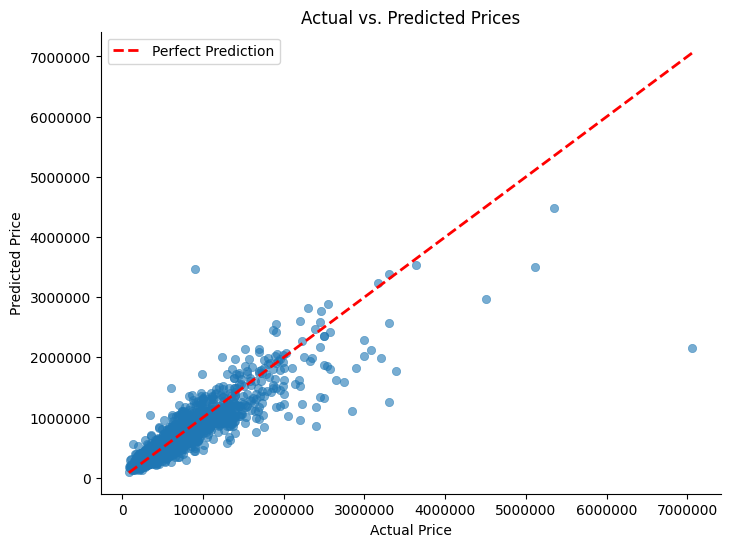

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pandas['original_price'], y=df_pandas['price_predicted'], alpha=0.6, edgecolor=None)

plt.plot([min(df_pandas['original_price']), max(df_pandas['original_price'])],
         [min(df_pandas['original_price']), max(df_pandas['original_price'])],
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.legend()
plt.show()


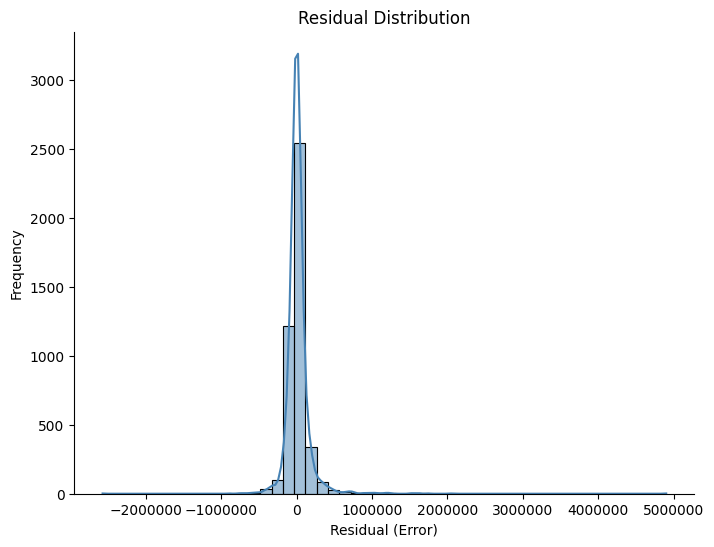

In [38]:
residuals = df_pandas['original_price'] - df_pandas['price_predicted']

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")

plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.show()


In [39]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost.spark import SparkXGBRegressor


paramGrid = (ParamGridBuilder()
             .addGrid(xgb.max_depth, [3, 5, 7])  # Tree depth
             .addGrid(xgb.learning_rate, [0.1, 0.2, 0.3])  # Learning rate (instead of eta)
             .addGrid(xgb.n_estimators, [50, 100, 150])  # Number of boosting iterations (instead of n_estimators)
             .build())


In [40]:
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")


In [41]:
cv = CrossValidator(estimator=xgb,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)  # 3-fold Cross Validation


In [42]:
cv_model = cv.fit(test_df_transformed)


INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

In [43]:
best_model = cv_model.bestModel


In [44]:
predictions = best_model.transform(test_df_transformed)


In [45]:
from pyspark.sql.functions import expm1

## IMPORTANT: Need to convert predictions back to original scale
predictions = predictions.withColumn("price_predicted", expm1(col("prediction")))
predictions = predictions.withColumn("original_price", expm1(col("price")))

In [46]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate RMSE using original numbers for interpretability
rmse_evaluator = RegressionEvaluator(labelCol="original_price", predictionCol="price_predicted", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

# Evaluate r squared
r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 135699.61697456124
R² Score: 0.896422374104771


In [47]:
df_pandas = predictions.toPandas()

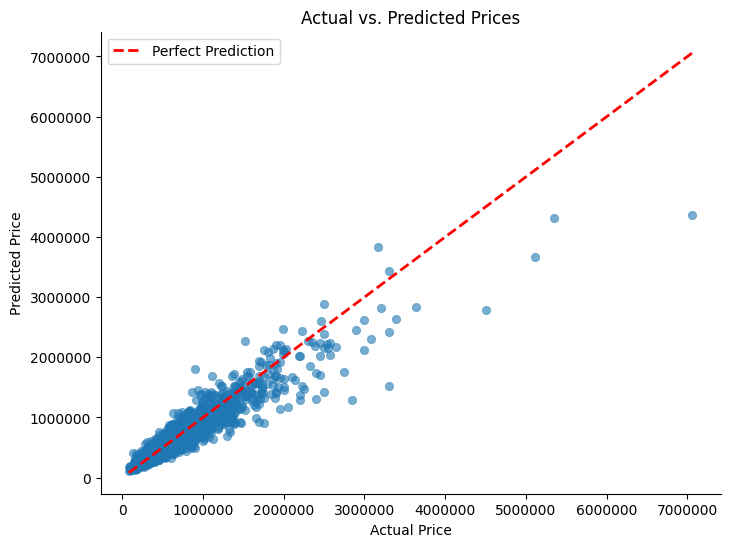

In [48]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pandas['original_price'], y=df_pandas['price_predicted'], alpha=0.6, edgecolor=None)

plt.plot([min(df_pandas['original_price']), max(df_pandas['original_price'])],
         [min(df_pandas['original_price']), max(df_pandas['original_price'])],
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.legend()
plt.show()


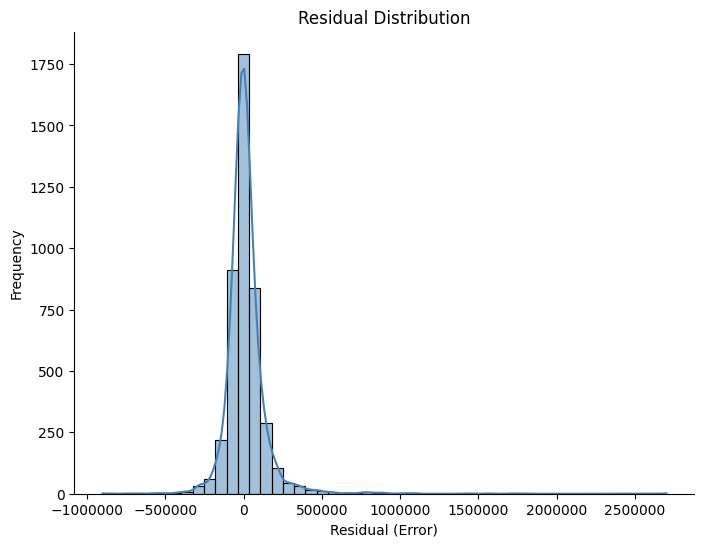

In [49]:
residuals = df_pandas['original_price'] - df_pandas['price_predicted']

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")

plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.show()
